In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/'Colab Notebooks'/AnyoneAI/final_project/main"
    %cd $ROOT_DIR

/content/drive/MyDrive/Colab Notebooks/AnyoneAI/final_project/main


In [4]:
pip install boto3 python_dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from src import config, data_utils, evaluation, plot

# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [4]:
dataset = pd.read_csv('clean_data.csv')

In [5]:
# perform random downsampling
sample_size = dataset['TARGET_LABEL_BAD=1'].value_counts().min()
dataset_resampled = pd.concat([dataset[dataset['TARGET_LABEL_BAD=1'] == c].sample(sample_size) for c in dataset['TARGET_LABEL_BAD=1'].unique()])
print('Resampled dataset shape %s' % dataset_resampled['TARGET_LABEL_BAD=1'].value_counts())

Resampled dataset shape TARGET_LABEL_BAD=1
1    13018
0    13018
Name: count, dtype: int64


In [6]:
dataset_resampled

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,MONTHS_IN_RESIDENCE,FLAG_EMAIL,COMPANY,...,PRODUCT,AGE,TARGET_LABEL_BAD=1,HAS_DEPENDANTS,HAS_RESIDENCE,MONTHLY_INCOMES_TOT,HAS_CARDS,HAS_BANKING_ACCOUNTS,HAS_PERSONAL_ASSETS,HAS_CARS
21789,1 - 14,Carga,M,single,1,CE,Y,0 - 6 months,1,Y,...,1,18 - 25,1,True,False,[0 - 650],True,True,False,True
22247,1 - 14,Carga,F,married,2,BA,Y,+ 1 year,0,Y,...,1,36 - 45,1,True,True,[0 - 650],True,True,False,True
3692,1 - 14,Web,M,single,0,PR,N,0 - 6 months,1,Y,...,1,26 - 35,1,False,False,[650 - 1320],False,False,False,False
23529,1 - 14,Carga,M,married,0,MG,Y,+ 1 year,1,N,...,2,46 - 60,1,False,True,[0 - 650],False,True,True,True
35638,1 - 14,Web,M,single,0,PE,Y,0 - 6 months,1,Y,...,1,36 - 45,1,False,True,[0 - 650],True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19802,1 - 14,Web,F,single,0,SP,Y,+ 1 year,1,N,...,1,26 - 35,0,False,True,[0 - 650],False,False,False,False
41522,1 - 14,Web,F,other,0,BA,Y,+ 1 year,1,N,...,7,> 60,0,False,True,[1320 - 3323],False,False,False,False
35579,15 - 30,Carga,F,single,2,PR,N,0 - 6 months,0,Y,...,1,26 - 35,0,True,True,[0 - 650],False,True,False,True
25686,1 - 14,Carga,F,married,2,RS,Y,6 months - 1 year,1,N,...,1,46 - 60,0,True,False,[650 - 1320],True,True,False,False


In [16]:
# first split in sets
app_train_set, app_val_set, app_test_set = data_utils.get_feature_in_set(dataset)

In [17]:
# second split features and target
train_prep, y_train, val_prep, y_val, test_prep, y_test = data_utils.get_feature_target(app_train_set,app_val_set,app_test_set)

In [18]:
app_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35953 entries, 26579 to 786
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   PAYMENT_DAY                  35953 non-null  object
 1   APPLICATION_SUBMISSION_TYPE  35953 non-null  object
 2   SEX                          35953 non-null  object
 3   MARITAL_STATUS               35953 non-null  object
 4   QUANT_DEPENDANTS             35953 non-null  int64 
 5   RESIDENCIAL_STATE            35953 non-null  object
 6   FLAG_RESIDENCIAL_PHONE       35953 non-null  object
 7   MONTHS_IN_RESIDENCE          35953 non-null  object
 8   FLAG_EMAIL                   35953 non-null  int64 
 9   COMPANY                      35953 non-null  object
 10  FLAG_PROFESSIONAL_PHONE      35953 non-null  object
 11  PRODUCT                      35953 non-null  int64 
 12  AGE                          35953 non-null  object
 13  TARGET_LABEL_BAD=1           35953

In [19]:
# third apply preprocess in sets
X_train, X_val, X_test, columns = data_utils.preprocess_data(train_prep,val_prep,test_prep)

Input train data shape:  (35953, 20)
Input val data shape:  (3995, 20)
Input test data shape:  (9987, 20) 

cat_cols:  Index(['PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE', 'SEX', 'MARITAL_STATUS',
       'RESIDENCIAL_STATE', 'FLAG_RESIDENCIAL_PHONE', 'MONTHS_IN_RESIDENCE',
       'COMPANY', 'FLAG_PROFESSIONAL_PHONE', 'AGE', 'HAS_DEPENDANTS',
       'HAS_RESIDENCE', 'MONTHLY_INCOMES_TOT', 'HAS_CARDS',
       'HAS_BANKING_ACCOUNTS', 'HAS_PERSONAL_ASSETS', 'HAS_CARS'],
      dtype='object')
['QUANT_DEPENDANTS', 'FLAG_EMAIL', 'PRODUCT']
Index(['PAYMENT_DAY', 'APPLICATION_SUBMISSION_TYPE', 'SEX',
       'FLAG_RESIDENCIAL_PHONE', 'COMPANY', 'FLAG_PROFESSIONAL_PHONE',
       'HAS_DEPENDANTS', 'HAS_RESIDENCE', 'HAS_CARDS', 'HAS_BANKING_ACCOUNTS',
       'HAS_PERSONAL_ASSETS', 'HAS_CARS'],
      dtype='object')
Index(['MARITAL_STATUS', 'RESIDENCIAL_STATE', 'MONTHS_IN_RESIDENCE', 'AGE',
       'MONTHLY_INCOMES_TOT'],
      dtype='object')


In [20]:
pd.DataFrame(X_train, columns=columns)

,transform_cat__MARITAL_STATUS_married,transform_cat__MARITAL_STATUS_other,transform_cat__MARITAL_STATUS_single,transform_cat__RESIDENCIAL_STATE_AC,transform_cat__RESIDENCIAL_STATE_AL,transform_cat__RESIDENCIAL_STATE_AM,transform_cat__RESIDENCIAL_STATE_AP,transform_cat__RESIDENCIAL_STATE_BA,transform_cat__RESIDENCIAL_STATE_CE,transform_cat__RESIDENCIAL_STATE_DF,...,transform_bin__FLAG_PROFESSIONAL_PHONE,transform_bin__HAS_DEPENDANTS,transform_bin__HAS_RESIDENCE,transform_bin__HAS_CARDS,transform_bin__HAS_BANKING_ACCOUNTS,transform_bin__HAS_PERSONAL_ASSETS,transform_bin__HAS_CARS,transform_num__QUANT_DEPENDANTS,transform_num__FLAG_EMAIL,transform_num__PRODUCT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
35949,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35950,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
35951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# logistic regression
model = LogisticRegression(max_iter=500)


In [33]:
# define the parameter grid to search over
param_grid = {
    # 'C': [0.01, 0.1, 1, 10],
	"class_weight": [{0:1,1:2}],
}

# create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5)

# fit the grid search object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': {0: 1, 1: 2}}
Best Score:  0.6882874958247338


In [34]:
print("model score: %.3f" % grid_search.score(X_val, y_val))
y_hat = grid_search.predict(X_test)

model score: 0.694


Model Performance metrics:
------------------------------
Accuracy: 0.6875938720336437
Precision: 0.7577313286884244
Recall: 0.8448957339512062
F1 Score: 0.7989431627787086

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      7337
           1       0.37      0.25      0.30      2650

    accuracy                           0.69      9987
   macro avg       0.56      0.55      0.55      9987
weighted avg       0.65      0.69      0.67      9987


Prediction Confusion Matrix:
------------------------------
      0     1
0  6199  1138
1  1982   668


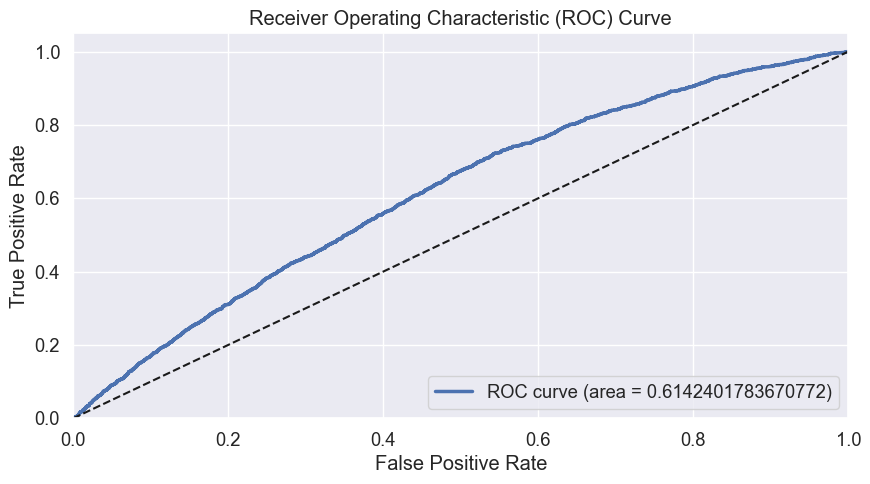

0.6142401783670772

In [35]:
accuracy = evaluation.get_performance(y_hat, y_test)
evaluation.plot_roc(grid_search, y_test, X_test)

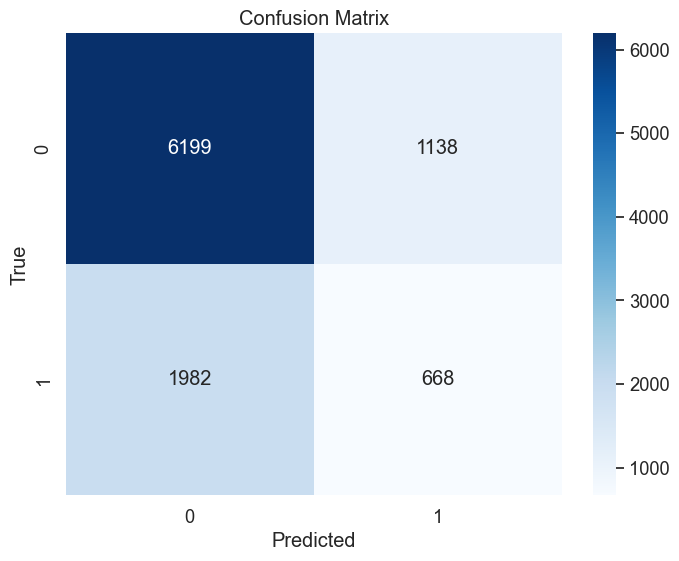

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Assuming you have y_test and y_hat
# y_test: true labels
# y_hat: predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_hat)

# Get class labels
class_labels = unique_labels(y_test, y_hat)

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [19]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [20]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(40, 50):
		rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
		model = LogisticRegression()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

In [21]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [22]:
# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X_train, y_train)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()